In [33]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
import re as re
import requests
import datetime
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

sb.set() # set the default Seaborn style for graphics

In [126]:
flightData_economy = pd.read_csv('https://raw.githubusercontent.com/chongwei49/IE0005-DSAI-Group-Barley/master/dataset/economy.csv')
flightData_business = pd.read_csv('https://raw.githubusercontent.com/chongwei49/IE0005-DSAI-Group-Barley/master/dataset/business.csv')

flightData_economy["class"] = "Economy"
flightData_business["class"] = "Business"

flightData = pd.concat([flightData_economy, flightData_business], ignore_index=True)
flightData

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,class
0,11-02-2022,SpiceJet,SG,8709,18:55,Delhi,02h 10m,non-stop,21:05,Mumbai,"5,953",Economy
1,11-02-2022,SpiceJet,SG,8157,06:20,Delhi,02h 20m,non-stop,08:40,Mumbai,"5,953",Economy
2,11-02-2022,AirAsia,I5,764,04:25,Delhi,02h 10m,non-stop,06:35,Mumbai,"5,956",Economy
3,11-02-2022,Vistara,UK,995,10:20,Delhi,02h 15m,non-stop,12:35,Mumbai,"5,955",Economy
4,11-02-2022,Vistara,UK,963,08:50,Delhi,02h 20m,non-stop,11:10,Mumbai,"5,955",Economy
...,...,...,...,...,...,...,...,...,...,...,...,...
300256,31-03-2022,Vistara,UK,822,09:45,Chennai,10h 05m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,19:50,Hyderabad,"69,265",Business
300257,31-03-2022,Vistara,UK,826,12:30,Chennai,10h 25m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,22:55,Hyderabad,"77,105",Business
300258,31-03-2022,Vistara,UK,832,07:05,Chennai,13h 50m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:55,Hyderabad,"79,099",Business
300259,31-03-2022,Vistara,UK,828,07:00,Chennai,10h 00m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,17:00,Hyderabad,"81,585",Business


In [127]:
flightData['date'] = pd.to_datetime(flightData['date'], format='%d-%m-%Y')
flightData['dayOfWeek'] = pd.to_datetime(flightData["date"].dt.strftime('%Y-%m-%d')).dt.day_name()
flightData['days_left'] = (flightData["date"] - datetime.datetime.strptime('2022-02-10', '%Y-%m-%d')).dt.days

flightData['flight'] = flightData['ch_code'].astype(str) + '-' + flightData['num_code'].astype(str)

flightData['stop'] = flightData['stop'].str.split(r'\n').str.get(0) #To clean 'stop' column

flightData['price'] = flightData['price'].str.replace(',', '') #To clean 'price' column
flightData['price'] = flightData['price'].astype('int64')

flightData['dep_time'] = flightData['dep_time'].str.replace(':', '') #To clean 'dep_time' column
flightData['dep_time'] = flightData['dep_time'].str.zfill(4) #To show time in HHMM format

flightData['arr_time'] = flightData['arr_time'].str.replace(':', '') #To clean 'arr_time' column
flightData['arr_time'] = flightData['arr_time'].str.zfill(4) #To show time in HHMM format

flightData['time_taken'] = flightData['time_taken'].str.replace('h','')
flightData['time_taken'] = flightData['time_taken'].str.replace('m','')
flightData['time_taken'] = (pd.to_numeric(flightData['time_taken'].str.split(' ').str.get(0), downcast="integer")*60) + pd.to_numeric(flightData['time_taken'].str.split(' ').str.get(1), downcast="integer")
def modify_stop(row):
  if "non-stop" in row['stop']:
    return 'zero'
  elif "1-stop" in row['stop']:
    return 'one'
  elif "2+-stop" in row['stop']:
    return 'two_or_more'
  else:
    return int(re.search(r'\d+', row['stop']).group())

flightData["stop"] = flightData.apply(modify_stop, axis=1) 

In [128]:
def find_day_period_dep(row):
  # Early Morning 4am-8am
  # Morning 8am-12pm
  # Afternoon 12pm-4pm
  # Evening 4pm-8pm
  # Night 8pm-12am
  # Late Night 12am-4am
    x = int(row["dep_time"])
    if(x>400 and x<=800):
      return "Early Morning"
    elif(x>800 and x<=1200):
      return "Morning"
    elif(x>1200 and x<=1600):
      return "Afternoon"
    elif(x>1600 and x<=2000):
      return "Evening"
    elif(x>2000 and x<=2400):
      return "Night" 
    else:
      return "Late Night"

def find_day_period_arrival(row):
  # Early Morning 4am-8am
  # Morning 8am-12pm
  # Afternoon 12pm-4pm
  # Evening 4pm-8pm
  # Night 8pm-12am
  # Late Night 12am-4am
    x = int(row["arr_time"])
    if(x>400 and x<=800):
      return "Early Morning"
    elif(x>800 and x<=1200):
      return "Morning"
    elif(x>1200 and x<=1600):
      return "Afternoon"
    elif(x>1600 and x<=2000):
      return "Evening"
    elif(x>2000 and x<=2400):
      return "Night" 
    else:
      return "Late Night"





flightData["departure_time"] = flightData.apply(find_day_period_dep, axis=1)
flightData["arrival_time"] = flightData.apply(find_day_period_arrival, axis=1)

flightData = flightData.rename(columns={'from': 'source_city', 'to': 'destination_city', 'stop': 'stops', 'time_taken': 'duration'})
flightData.drop(columns=['dep_time', 'arr_time','ch_code', 'num_code', 'date', 'dayOfWeek'], axis=1, inplace=True) 
flightData

,airline,source_city,duration,stops,destination_city,price,class,days_left,flight,departure_time,arrival_time
0,SpiceJet,Delhi,130.0,zero,Mumbai,5953,Economy,1,SG-8709,Evening,Night
1,SpiceJet,Delhi,140.0,zero,Mumbai,5953,Economy,1,SG-8157,Early Morning,Morning
2,AirAsia,Delhi,130.0,zero,Mumbai,5956,Economy,1,I5-764,Early Morning,Early Morning
3,Vistara,Delhi,135.0,zero,Mumbai,5955,Economy,1,UK-995,Morning,Afternoon
4,Vistara,Delhi,140.0,zero,Mumbai,5955,Economy,1,UK-963,Morning,Morning
...,...,...,...,...,...,...,...,...,...,...,...
300256,Vistara,Chennai,605.0,one,Hyderabad,69265,Business,49,UK-822,Morning,Evening
300257,Vistara,Chennai,625.0,one,Hyderabad,77105,Business,49,UK-826,Afternoon,Night
300258,Vistara,Chennai,830.0,one,Hyderabad,79099,Business,49,UK-832,Early Morning,Night
300259,Vistara,Chennai,600.0,one,Hyderabad,81585,Business,49,UK-828,Early Morning,Evening


In [129]:
print("Data type : ", type(flightData))
print("Data dims : ", flightData.shape)
print(flightData.dtypes)

Data type :  <class 'pandas.core.frame.DataFrame'>
Data dims :  (300261, 11)
airline              object
source_city          object
duration            float64
stops                object
destination_city     object
price                 int64
class                object
days_left             int64
flight               object
departure_time       object
arrival_time         object
dtype: object


In [130]:
# A Quick Information abou the Data
flightData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300261 entries, 0 to 300260
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300261 non-null  object 
 1   source_city       300261 non-null  object 
 2   duration          300257 non-null  float64
 3   stops             300261 non-null  object 
 4   destination_city  300261 non-null  object 
 5   price             300261 non-null  int64  
 6   class             300261 non-null  object 
 7   days_left         300261 non-null  int64  
 8   flight            300261 non-null  object 
 9   departure_time    300261 non-null  object 
 10  arrival_time      300261 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 25.2+ MB


In [131]:
# Stastical Description of Data
flightData.describe()

,duration,price,days_left
count,300257.000000,300261.000000,300261.000000
mean,733.074383,20883.717666,26.004473
std,431.572124,22695.911266,13.560985
min,50.000000,1105.000000,1.000000
25%,405.000000,4783.000000,15.000000
50%,675.000000,7425.000000,26.000000
75%,970.000000,42521.000000,38.000000
max,2990.000000,123071.000000,49.000000


In [132]:
# Find correlation variables (non-object varaibles)
flightData.corr()

,duration,price,days_left
duration,1.000000,0.204462,-0.039123
price,0.204462,1.000000,-0.091917
days_left,-0.039123,-0.091917,1.000000


In [133]:
flightData1=flightData.groupby(['flight','airline'],as_index=False).count()
flightData1.airline.value_counts()

Indigo       704
Air India    218
GO FIRST     205
SpiceJet     186
Vistara      133
AirAsia      115
Trujet         4
StarAir        4
Name: airline, dtype: int64

In [142]:
flightData = flightData[~flightData['airline'].str.contains("Trujet")]
flightData = flightData[~flightData['airline'].str.contains("StarAir")]
flightData

,airline,source_city,duration,stops,destination_city,price,class,days_left,flight,departure_time,arrival_time
0,SpiceJet,Delhi,130.0,zero,Mumbai,5953,Economy,1,SG-8709,Evening,Night
1,SpiceJet,Delhi,140.0,zero,Mumbai,5953,Economy,1,SG-8157,Early Morning,Morning
2,AirAsia,Delhi,130.0,zero,Mumbai,5956,Economy,1,I5-764,Early Morning,Early Morning
3,Vistara,Delhi,135.0,zero,Mumbai,5955,Economy,1,UK-995,Morning,Afternoon
4,Vistara,Delhi,140.0,zero,Mumbai,5955,Economy,1,UK-963,Morning,Morning
...,...,...,...,...,...,...,...,...,...,...,...
300256,Vistara,Chennai,605.0,one,Hyderabad,69265,Business,49,UK-822,Morning,Evening
300257,Vistara,Chennai,625.0,one,Hyderabad,77105,Business,49,UK-826,Afternoon,Night
300258,Vistara,Chennai,830.0,one,Hyderabad,79099,Business,49,UK-832,Early Morning,Night
300259,Vistara,Chennai,600.0,one,Hyderabad,81585,Business,49,UK-828,Early Morning,Evening


In [143]:
print("Table after dropping outlying Airlines")
flightData1=flightData.groupby(['flight','airline'],as_index=False).count()
flightData1.airline.value_counts()

Table after dropping outlying Airlines


Indigo       704
Air India    218
GO FIRST     205
SpiceJet     186
Vistara      133
AirAsia      115
Name: airline, dtype: int64

In [144]:
# Find correlation variables (non-object varaibles)
flightData.corr()

,duration,price,days_left
duration,1.000000,0.204216,-0.039158
price,0.204216,1.000000,-0.091939
days_left,-0.039158,-0.091939,1.000000


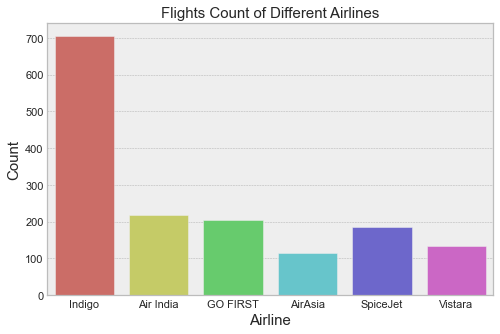

In [145]:
plt.style.use('bmh')
plt.figure(figsize=(8,5))
sb.countplot(flightData1['airline'],palette='hls')
plt.title('Flights Count of Different Airlines',fontsize=15)
plt.xlabel('Airline',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.show()

### Indigo has the highest flight counts, which means it operates the most number of routes within india

In [146]:
flightData2=flightData.groupby(['flight','airline','class'],as_index=False).count()
flightData2['class'].value_counts()

Economy     1560
Business     295
Name: class, dtype: int64

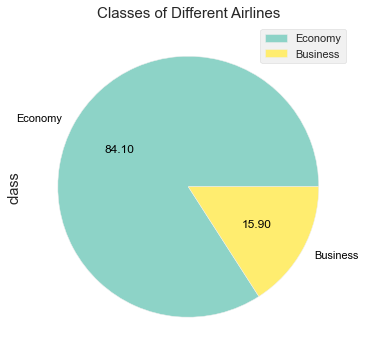

In [147]:
plt.figure(figsize=(8,6))
flightData2['class'].value_counts().plot(kind='pie',textprops={'color':'black'},autopct='%.2f',cmap='Set3')
plt.title('Classes of Different Airlines',fontsize=15)
plt.legend(['Economy','Business'])
plt.show()

### Most airlines has more Economy flights than business

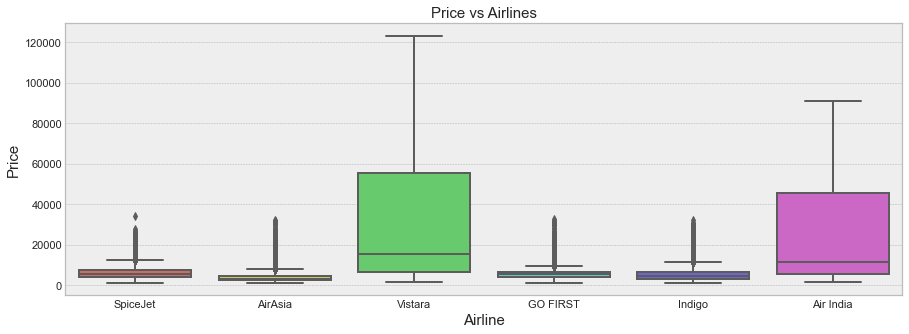

In [148]:
plt.figure(figsize=(15,5))
sb.boxplot(x=flightData['airline'],y=flightData['price'],palette='hls')
plt.title('Price vs Airlines',fontsize=15)
plt.xlabel('Airline',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

### [Price against Airlines]
##### 1.We can see that Vistara has the highest price range
##### 2.Vistara and Air India has higher price range compared to the 4 other airlines
##### 3.SpiceJet, AirAsia, GO FIRST and Indigo has similar price range

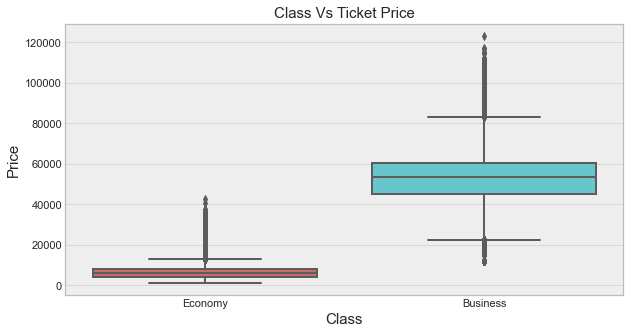

In [149]:
plt.figure(figsize=(10,5))
sb.boxplot(x='class',y='price',data=flightData,palette='hls')
plt.title('Class Vs Ticket Price',fontsize=15)
plt.xlabel('Class',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

### [Price against Class]
##### 1.Bussiness Class has a higher price range compared to Economy Class

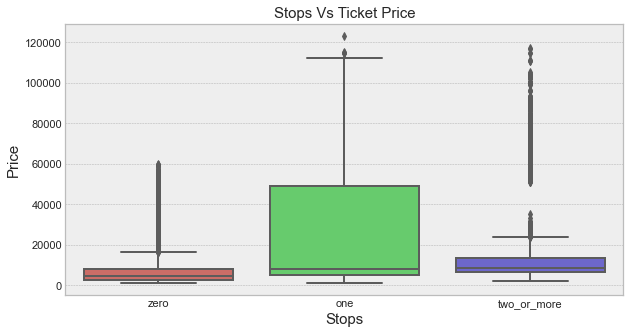

In [150]:
plt.figure(figsize=(10,5))
sb.boxplot(x='stops',y='price',data=flightData,palette='hls')
plt.title('Stops Vs Ticket Price',fontsize=15)
plt.xlabel('Stops',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

### [Price against Stops]
##### 1. Flights that stops once, has highest price range

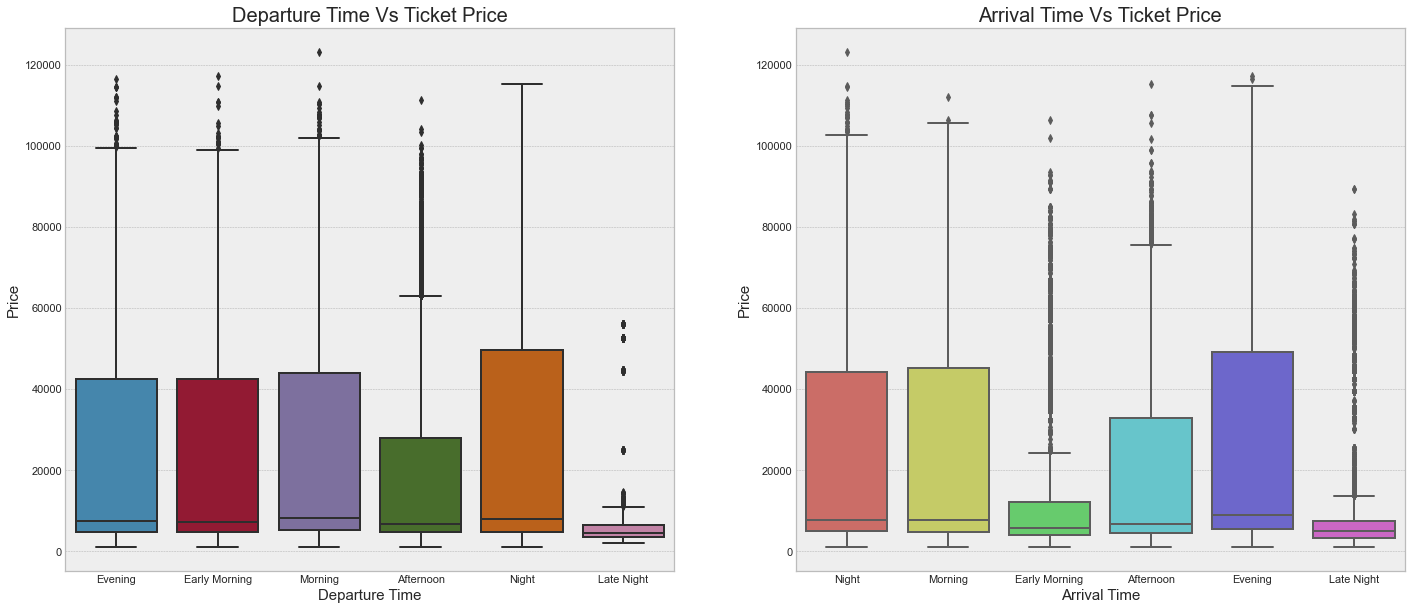

In [151]:
plt.figure(figsize=(24,10))
plt.subplot(1,2,1)
sb.boxplot(x='departure_time',y='price',data=flightData)
plt.title('Departure Time Vs Ticket Price',fontsize=20)
plt.xlabel('Departure Time',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.subplot(1,2,2)
sb.boxplot(x='arrival_time',y='price',data=flightData,palette='hls')
plt.title('Arrival Time Vs Ticket Price',fontsize=20)
plt.xlabel('Arrival Time',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

### [Price against Departure Time]
##### 1. Ticket Price is higher for the Flights when the Departure Time is at Night
##### 2. Ticket Price is almost equal for flights Having Departure time at Early_morning , Morning and Evening
##### 3. Ticket Price is lower for the Flights Having Departure Time at Late_night

### [Price against Arrival Time]
##### 1. Ticket Price is higher for the Flights when the Arrival Time is at Evening
##### 2. Ticket Price is almost equal for flights Having Arrival time is at Morning and Night
##### 3. Ticket Price is lower for the Flights Having Arrival Time at Late_night as same as Departure Time

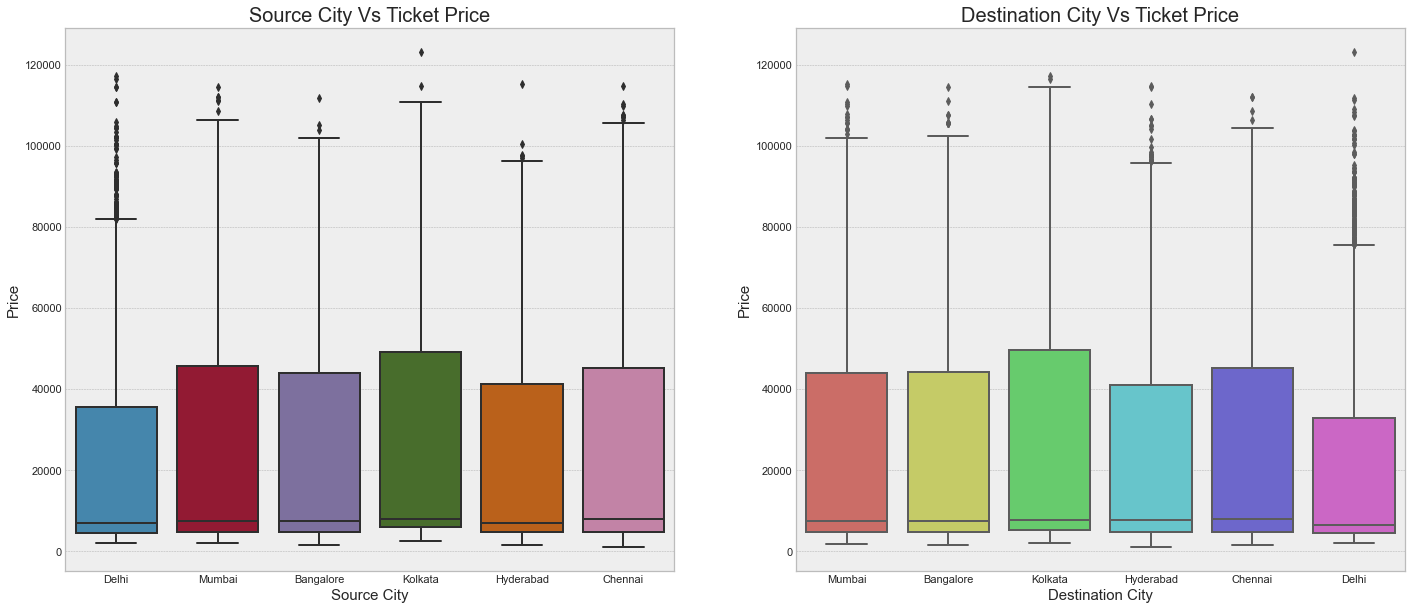

In [152]:
plt.figure(figsize=(24,10))
plt.subplot(1,2,1)
sb.boxplot(x='source_city',y='price',data=flightData)
plt.title('Source City Vs Ticket Price',fontsize=20)
plt.xlabel('Source City',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.subplot(1,2,2)
sb.boxplot(x='destination_city',y='price',data=flightData,palette='hls')
plt.title('Destination City Vs Ticket Price',fontsize=20)
plt.xlabel('Destination City',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

### [Price against Source City]
##### 1. Ticket Price is higher for the Flights whose Source City is Kolkata
##### 2. Ticket Price is almost equal for flights Having Source Cities as Mumbai and chennai , Hyderabad and Bangalore
##### 3. Ticket Price is lower for the Flights Having Source City as Delhi

### [Price against Destination City]
##### 1. Ticket Price is higher for the Flights whose Destination City is kolkata and Chennai
##### 2. Ticket Price is almost equal for flights Having Destination Cities as Mumbai and Bangalore
##### 3. Ticket Price is lower for the Flights Having Destination City as Delhi

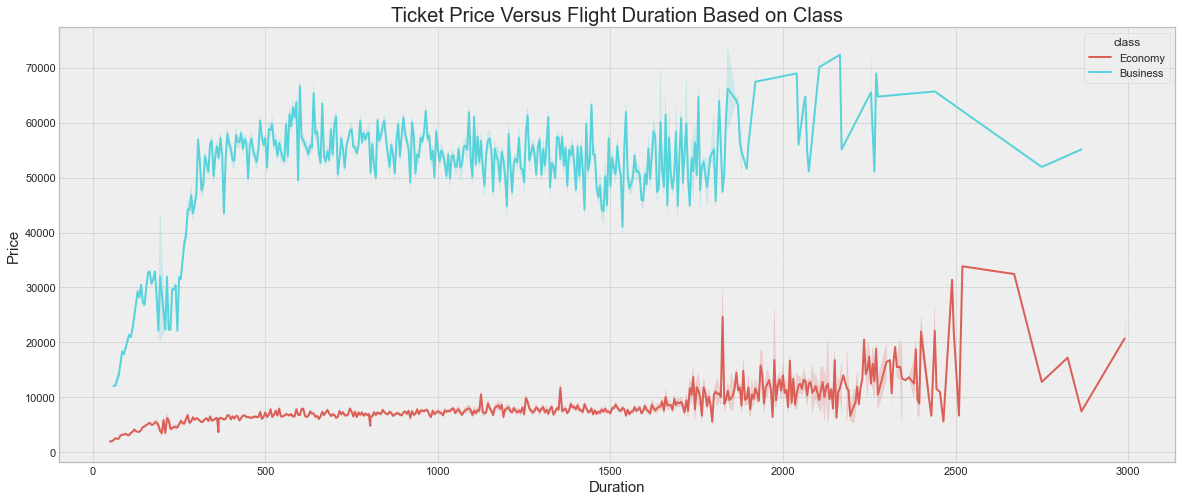

In [153]:
plt.figure(figsize=(20,8))
sb.lineplot(data=flightData,x='duration',y='price',hue='class',palette='hls')
plt.title('Ticket Price Versus Flight Duration Based on Class',fontsize=20)
plt.xlabel('Duration',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

### [Price against Duration(Hours) based on Class]
##### 1. With increase in Duration, the Ticket Price is also Increases In both the Economy and Business classes

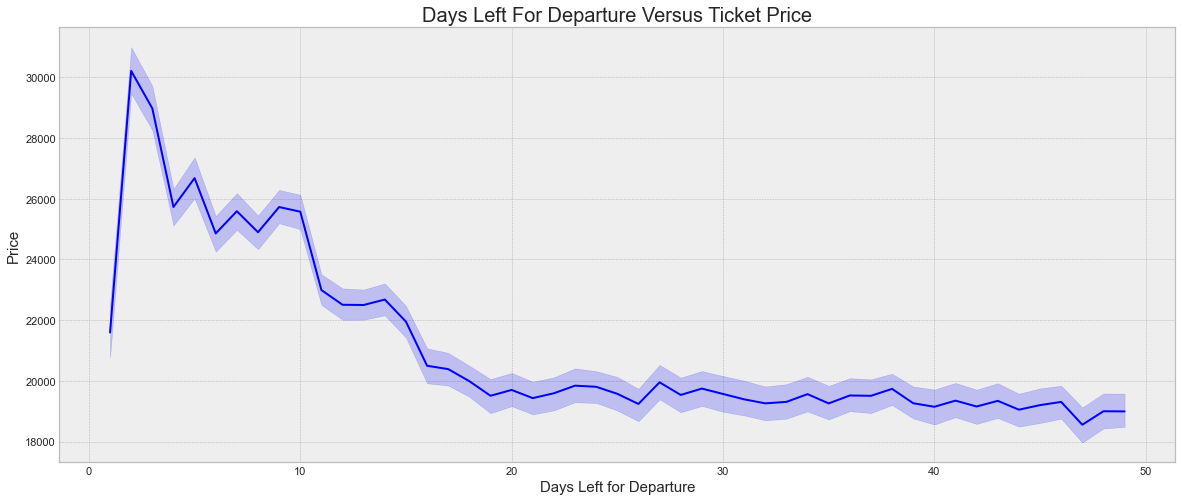

In [154]:
plt.figure(figsize=(20,8))
sb.lineplot(data=flightData,x='days_left',y='price',color='blue')
plt.title('Days Left For Departure Versus Ticket Price',fontsize=20)
plt.xlabel('Days Left for Departure',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

### [Price against Days Left for Departure]
##### 1. Based on the graph, price gradually increases as days left for departure decreases. However price will peak a few days before departure before decreasing drastically.

In [155]:
flightData.groupby(['flight','source_city','destination_city','airline','class'],as_index=False).count().groupby(['source_city','destination_city'],as_index=False)['flight'].count().head(10)

,source_city,destination_city,flight
0,Bangalore,Chennai,106
1,Bangalore,Delhi,227
2,Bangalore,Hyderabad,132
3,Bangalore,Kolkata,171
4,Bangalore,Mumbai,175
5,Chennai,Bangalore,69
6,Chennai,Delhi,105
7,Chennai,Hyderabad,82
8,Chennai,Kolkata,110
9,Chennai,Mumbai,94


### Total number of Flights from one city to another

In [105]:
flightData.groupby(['airline','source_city','destination_city'],as_index=False)['price'].mean()

,airline,source_city,destination_city,price
0,Air India,Bangalore,Chennai,26765.567702
1,Air India,Bangalore,Delhi,20699.099886
2,Air India,Bangalore,Hyderabad,23395.956912
3,Air India,Bangalore,Kolkata,29105.826259
4,Air India,Bangalore,Mumbai,25625.530802
...,...,...,...,...
172,Vistara,Mumbai,Bangalore,35029.880315
173,Vistara,Mumbai,Chennai,32181.946251
174,Vistara,Mumbai,Delhi,26402.695114
175,Vistara,Mumbai,Hyderabad,29497.578017


### Average Price of different Airlnes from Source city to Destination city

# -------------------------------------------Prediction----------------------------------------------------

In [74]:
# Creating a Back up File
df = flightData.copy()
df = df.reset_index()
df_bk=df.copy()

In [75]:
# Coverting the labels into a numeric form using Label Encoder
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
for col in df.columns:
    if df[col].dtype=='object':
        df[col]=le.fit_transform(df[col])

In [76]:
# storing the Dependent Variables in X and Independent Variable in Y
x=df.drop(['price'],axis=1)
y=df['price']

In [77]:
# Splitting the Data into Training set and Testing Set
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.30,random_state=42)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((210111, 11), (90048, 11), (210111,), (90048,))

In [78]:
# Scaling the values to convert the int values to Machine Languages
from sklearn.preprocessing import MinMaxScaler
mmscaler=MinMaxScaler(feature_range=(0,1))
x_train=mmscaler.fit_transform(x_train)
x_test=mmscaler.fit_transform(x_test)
x_train=pd.DataFrame(x_train)
x_test=pd.DataFrame(x_test)  

In [79]:
a={'Model Name':[], 'Mean_Absolute_Error_MAE':[] ,'Adj_R_Square':[] ,'Root_Mean_Squared_Error_RMSE':[] ,'Mean_Absolute_Percentage_Error_MAPE':[] ,'Mean_Squared_Error_MSE':[] ,'Root_Mean_Squared_Log_Error_RMSLE':[] ,'R2_score':[]}
Results=pd.DataFrame(a)
Results.head()

,Model Name,Mean_Absolute_Error_MAE,Adj_R_Square,Root_Mean_Squared_Error_RMSE,Mean_Absolute_Percentage_Error_MAPE,Mean_Squared_Error_MSE,Root_Mean_Squared_Log_Error_RMSLE,R2_score


In [80]:
# Build the Regression / Regressor models

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Create objects of Regression / Regressor models with default hyper-parameters

modelmlg = LinearRegression()
modeldcr = DecisionTreeRegressor()
modelbag = BaggingRegressor()
modelrfr = RandomForestRegressor()
modelSVR = SVR()
modelXGR = xgb.XGBRegressor()
modelKNN = KNeighborsRegressor(n_neighbors=5)
modelETR = ExtraTreesRegressor()
modelRE=Ridge()
modelLO=linear_model.Lasso(alpha=0.1)

modelGBR = GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=100, subsample=1.0,
                                     criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1,
                                     min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0,
                                     init=None, random_state=None, max_features=None,
                                     alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False,
                                     validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)

# Evalution matrix for all the algorithms

MM = [modelmlg, modeldcr, modelrfr, modelKNN, modelETR, modelGBR, modelXGR, modelbag,modelRE,modelLO]

for models in MM:
    
    # Fit the model with train data
    
    models.fit(x_train, y_train)
    
    # Predict the model with test data

    y_pred = models.predict(x_test)
    
    # Print the model name
    
    print('Model Name: ', models)
    
    # Evaluation metrics for Regression analysis

    from sklearn import metrics

    print('Mean Absolute Error (MAE):', round(metrics.mean_absolute_error(y_test, y_pred),3))  
    print('Mean Squared Error (MSE):', round(metrics.mean_squared_error(y_test, y_pred),3))  
    print('Root Mean Squared Error (RMSE):', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),3))
    print('R2_score:', round(metrics.r2_score(y_test, y_pred),6))
    print('Root Mean Squared Log Error (RMSLE):', round(np.log(np.sqrt(metrics.mean_squared_error(y_test, y_pred))),3))
    
    # Define the function to calculate the MAPE - Mean Absolute Percentage Error

    def MAPE (y_test, y_pred):
        y_test, y_pred = np.array(y_test), np.array(y_pred)
        return np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    # Evaluation of MAPE 

    result = MAPE(y_test, y_pred)
    print('Mean Absolute Percentage Error (MAPE):', round(result, 2), '%')
    
    # Calculate Adjusted R squared values 

    r_squared = round(metrics.r2_score(y_test, y_pred),6)
    adjusted_r_squared = round(1 - (1-r_squared)*(len(y)-1)/(len(y)-x.shape[1]-1),6)
    print('Adj R Square: ', adjusted_r_squared)
    print('------------------------------------------------------------------------------------------------------------')
    #-------------------------------------------------------------------------------------------
    new_row = {'Model Name' : models,
               'Mean_Absolute_Error_MAE' : metrics.mean_absolute_error(y_test, y_pred),
               'Adj_R_Square' : adjusted_r_squared,
               'Root_Mean_Squared_Error_RMSE' : np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
               'Mean_Absolute_Percentage_Error_MAPE' : result,
               'Mean_Squared_Error_MSE' : metrics.mean_squared_error(y_test, y_pred),
               'Root_Mean_Squared_Log_Error_RMSLE': np.log(np.sqrt(metrics.mean_squared_error(y_test, y_pred))),
               'R2_score' : metrics.r2_score(y_test, y_pred)}
    Results = Results.append(new_row, ignore_index=True)
    #------------------------------------------------------------

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [71]:
Results

,Model Name,Mean_Absolute_Error_MAE,Adj_R_Square,Root_Mean_Squared_Error_RMSE,Mean_Absolute_Percentage_Error_MAPE,Mean_Squared_Error_MSE,Root_Mean_Squared_Log_Error_RMSLE,R2_score


In [ ]:
models=['LinearRegression','DecisionTreeRegressor','RandomForestRegressor','KNeighborsRegressor','ExtraTreesRegressor','GradientBoostingRegressor','XGBRegressor','BaggingRegressor','Ridge Regression','Lasso Regression']
result=pd.DataFrame({'Model_Name':models})
result['Adj_R_Square']=Results['Adj_R_Square']
result['Mean_Absolute_Error_MAE']=Results['Mean_Absolute_Error_MAE']
result['Root_Mean_Squared_Error_RMSE']=Results['Root_Mean_Squared_Error_RMSE']
result['Mean_Absolute_Percentage_Error_MAPE']=Results['Mean_Absolute_Percentage_Error_MAPE']
result['Mean_Squared_Error_MSE']=Results['Mean_Squared_Error_MSE']
result['Root_Mean_Squared_Log_Error_RMSLE']=Results['Root_Mean_Squared_Log_Error_RMSLE']
result['R2_score']=Results['R2_score']
result=result.sort_values(by='Adj_R_Square',ascending=False).reset_index(drop=True)
result